# Prediction Notebook — Streamlined & Explained

This optimized version keeps your original functionality but simplifies structure and clarifies the narrative.
Use the **Table of Contents** to jump to any step; each code cell has a matching heading and a one‑line purpose.

## What you’ll do here
- Set up the environment and imports
- Load and prepare data
- (Optionally) build preprocessing
- Train a model
- Make predictions
- Evaluate performance
- Save outputs & figures

## How to run
1. Run **Step 1 – Setup** first (it collects all imports in one place and sets deterministic seeds where available).
2. Then run each subsequent step top‑to‑bottom. You can also run individual steps independently if your data and variables are already in memory.

---
## Table of Contents
- [Step 1 — Setup](#step-1-setup)

- [Step 2 — Load data](#step-2-load-data)
- [Step 3 — Load data](#step-3-load-data)
- [Step 4 — Train model](#step-4-train-model)
- [Step 5 — Train model](#step-5-train-model)
- [Step 6 — Visualize results](#step-6-visualize-results)
- [Step 7 — Visualize results](#step-7-visualize-results)
- [Step 8 — Train model](#step-8-train-model)
- [Step 9 — Train model](#step-9-train-model)
- [Step 10 — Train model](#step-10-train-model)
- [Step 11 — Visualize results](#step-11-visualize-results)
- [Step 12 — Visualize results](#step-12-visualize-results)

In [7]:
# Step 1 — Setup
# Consolidated imports and (optional) determinism for reproducibility

import pandas as pd
from pathlib import Path
import numpy as np
from collections import Counter, defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import Counter
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from collections import deque

# Deterministic seeds (if relevant modules are present)
SEED = 42
import numpy as np  # ensured above if present originally
np.random.seed(SEED)

---

## Subsequent steps

### Step 2 — Load data
<a id='step-2-load-data'></a>

**Purpose:** Load data.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

In [8]:
# Step 2 — Load data
CSV = Path(r"/Users/tim/Desktop/DTU/BA/Project/Coding/trips_2018.csv")

# Read a small chunk just to preview *cleaned* rows
iter_csv = pd.read_csv(
    CSV,
    chunksize=100_000,         # small preview chunk
    low_memory=False,
    usecols=[
        "tripduration","starttime","stoptime",
        "start_station_id","start_station_latitude","start_station_longitude",
        "end_station_id","end_station_latitude","end_station_longitude",
        "bikeid","usertype","birth_year","gender","Unnamed: 0"
    ],
)

def clean_chunk(df: pd.DataFrame) -> pd.DataFrame:
    # drop index-ish column if present
    df = df.drop(columns=[c for c in ["Unnamed: 0"] if c in df.columns], errors="ignore")

    # rename to our standard schema for the rest of the project
    rename_map = {
        "starttime": "started_at",
        "stoptime": "ended_at",
        "start_station_id": "start_station_id",
        "end_station_id": "end_station_id",
        "start_station_latitude": "start_lat",
        "start_station_longitude": "start_lng",
        "end_station_latitude": "end_lat",
        "end_station_longitude": "end_lng",
    }
    df = df.rename(columns=rename_map)

    # parse datetimes; keep naive for now (we can localize later if needed)
    df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
    df["ended_at"]   = pd.to_datetime(df["ended_at"],   errors="coerce")

    # derive hourly buckets (both start and end — useful later)
    df["hour_start"] = df["started_at"].dt.floor("h")
    df["hour_end"]   = df["ended_at"].dt.floor("h")

    # numeric cleanups (coerce → NA, then use nullable dtypes)
    for col in ["start_station_id","end_station_id","bikeid","birth_year","gender","tripduration"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # dtypes (nullable to keep NAs)
    if "start_station_id" in df: df["start_station_id"] = df["start_station_id"].astype("Int32")
    if "end_station_id"   in df: df["end_station_id"]   = df["end_station_id"].astype("Int32")
    if "bikeid"           in df: df["bikeid"]           = df["bikeid"].astype("Int32")
    if "birth_year"       in df: df["birth_year"]       = df["birth_year"].astype("Int16")
    if "gender"           in df: df["gender"]           = df["gender"].astype("Int8")
    if "tripduration"     in df: df["tripduration"]     = df["tripduration"].astype("Int32")

    # lat/lng to float32 and basic sanity (within world bounds)
    for c in ["start_lat","start_lng","end_lat","end_lng"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
    if {"start_lat","start_lng","end_lat","end_lng"}.issubset(df.columns):
        bad = (
            (df["start_lat"].abs() > 90) | (df["end_lat"].abs() > 90) |
            (df["start_lng"].abs() > 180) | (df["end_lng"].abs() > 180)
        )
        df = df.loc[~bad]

    # categories keep memory low and are nice for strings
    if "usertype" in df.columns:
        df["usertype"] = df["usertype"].astype("category")

    # reorder columns for readability
    cols = [
        "hour_start","hour_end","started_at","ended_at",
        "start_station_id","start_lat","start_lng",
        "end_station_id","end_lat","end_lng",
        "tripduration","bikeid","usertype","birth_year","gender",
    ]
    cols = [c for c in cols if c in df.columns]
    return df[cols]

# preview cleaned chunk
for raw in iter_csv:
    cleaned = clean_chunk(raw)
    display(cleaned.head(10))
    display(cleaned.dtypes)
    break


,hour_start,hour_end,started_at,ended_at,start_station_id,start_lat,start_lng,end_station_id,end_lat,end_lng,tripduration,bikeid,usertype,birth_year,gender
0,2018-01-01 13:00:00,2018-01-01 14:00:00,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767273,-73.993927,505,40.749012,-73.988487,970,31956,Subscriber,1992,1
1,2018-01-01 15:00:00,2018-01-01 15:00:00,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767273,-73.993927,3255,40.750584,-73.994682,723,32536,Subscriber,1969,1
2,2018-01-01 15:00:00,2018-01-01 15:00:00,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767273,-73.993927,525,40.755943,-74.002113,496,16069,Subscriber,1956,1
3,2018-01-01 15:00:00,2018-01-01 15:00:00,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767273,-73.993927,447,40.763706,-73.985161,306,31781,Subscriber,1974,1
4,2018-01-01 18:00:00,2018-01-01 18:00:00,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767273,-73.993927,3356,40.774666,-73.984703,306,30319,Subscriber,1992,1
5,2018-01-01 21:00:00,2018-01-01 21:00:00,2018-01-01 21:31:54.192,2018-01-01 21:58:36.353,72,40.767273,-73.993927,482,40.739357,-73.999321,1602,30106,Subscriber,1968,1
6,2018-01-02 07:00:00,2018-01-02 08:00:00,2018-01-02 07:54:53.646,2018-01-02 08:06:55.872,72,40.767273,-73.993927,228,40.754601,-73.971878,722,32059,Subscriber,1978,1
7,2018-01-02 08:00:00,2018-01-02 08:00:00,2018-01-02 08:06:14.331,2018-01-02 08:13:28.767,72,40.767273,-73.993927,173,40.760685,-73.984528,434,30525,Subscriber,1983,1
8,2018-01-02 08:00:00,2018-01-02 08:00:00,2018-01-02 08:10:15.255,2018-01-02 08:16:21.896,72,40.767273,-73.993927,479,40.760193,-73.991257,366,27439,Subscriber,1974,1
9,2018-01-02 08:00:00,2018-01-02 08:00:00,2018-01-02 08:13:30.896,2018-01-02 08:18:55.120,72,40.767273,-73.993927,450,40.762272,-73.987885,324,30892,Subscriber,1947,1


hour_start          datetime64[ns]
hour_end            datetime64[ns]
started_at          datetime64[ns]
ended_at            datetime64[ns]
start_station_id             Int32
start_lat                  float32
start_lng                  float32
end_station_id               Int32
end_lat                    float32
end_lng                    float32
tripduration                 Int32
bikeid                       Int32
usertype                  category
birth_year                   Int16
gender                        Int8
dtype: object

### Step 3 — Load data
<a id='step-3-load-data'></a>

**Purpose:** Load data.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

In [10]:
# Step 3 — Load data
# === [A] Build Station Master + K-Means Clusters (in-memory) =================

# ---- 0) Configure how to read the (possibly split) CSVs ---------------------
# If you have a folder with many CSV parts, point DATA_PATH to that folder.
# If you have a single file, point DATA_PATH to that file.
DATA_PATH = Path(r"/Users/tim/Desktop/DTU/BA/Project/Coding/")

# Pattern for split files (change if needed). If DATA_PATH is a file, we’ll just use it.
GLOB_PATTERN = "trips_2018.csv"    # e.g., trips_2018.csv, trips_2019.csv, ...
CHUNKSIZE = 250_000

USECOLS = [
    "tripduration","starttime","stoptime",
    "start_station_id","start_station_latitude","start_station_longitude",
    "end_station_id","end_station_latitude","end_station_longitude",
    "bikeid","usertype","birth_year","gender","Unnamed: 0"
]

def _iter_paths(path: Path):
    if path.is_file():
        yield path
    else:
        files = sorted(path.glob(GLOB_PATTERN))
        if not files:
            raise FileNotFoundError(f"No files found under {path} with pattern {GLOB_PATTERN}")
        for fp in files:
            yield fp

def yield_clean_chunks():
    """Yield cleaned chunks using the *existing* clean_chunk(df) you defined earlier."""
    for fp in _iter_paths(DATA_PATH):
        print(f"Reading: {fp.name}")
        reader = pd.read_csv(fp, chunksize=CHUNKSIZE, low_memory=False, usecols=USECOLS)
        for raw in reader:
            yield clean_chunk(raw)

# ---- 1) Station master: station_id → (lat, lon) -----------------------------
# Build by counting coordinate occurrences and keeping the most frequent per station.

coord_counts = defaultdict(Counter)  # station_id -> Counter({(lat, lon): count})
n_chunks = 0
for chunk in yield_clean_chunks():
    n_chunks += 1
    # from start stations
    s = chunk[["start_station_id","start_lat","start_lng"]].dropna()
    if not s.empty:
        for sid, lat, lng in s.itertuples(index=False):
            coord_counts[int(sid)][(float(lat), float(lng))] += 1
    # from end stations
    e = chunk[["end_station_id","end_lat","end_lng"]].dropna()
    if not e.empty:
        for sid, lat, lng in e.itertuples(index=False):
            coord_counts[int(sid)][(float(lat), float(lng))] += 1

    if n_chunks % 10 == 0:
        print(f"  processed {n_chunks} chunks... stations so far: {len(coord_counts)}")

# choose the most frequent (lat, lon) per station
rows = []
for sid, ctr in coord_counts.items():
    (lat, lon), _ = ctr.most_common(1)[0]
    rows.append((sid, lat, lon))

station_master = pd.DataFrame(rows, columns=["station_id","lat","lon"])
station_master["station_id"] = station_master["station_id"].astype("Int32")
station_master[["lat","lon"]] = station_master[["lat","lon"]].astype("float32")

print("Station master built.")
display(station_master.head())
display(station_master.dtypes)
print("Stations:", len(station_master))

# ---- 2) K-Means clustering on (lat, lon) ------------------------------------

K = 24   # >=20 as per task; change if needed
km = KMeans(n_clusters=K, n_init=10, random_state=42)
labels = km.fit_predict(station_master[["lat","lon"]].to_numpy())

cluster_map = station_master[["station_id"]].copy()
cluster_map["cluster_id"] = labels.astype(np.int32)

print("Clustering done.")
display(cluster_map.head())
print("Unique clusters:", cluster_map["cluster_id"].nunique())

# (Optional later) persist tiny artifact:
# cluster_map.to_csv("cluster_map.csv", index=False)


Reading: trips_2018.csv
  processed 10 chunks... stations so far: 781
  processed 20 chunks... stations so far: 804
  processed 30 chunks... stations so far: 816
  processed 40 chunks... stations so far: 829
  processed 50 chunks... stations so far: 837
  processed 60 chunks... stations so far: 841
  processed 70 chunks... stations so far: 850
Station master built.


,station_id,lat,lon
0,72,40.767273,-73.993927
1,79,40.719116,-74.006668
2,82,40.711174,-74.000168
3,83,40.683826,-73.976326
4,119,40.696091,-73.978035


station_id      Int32
lat           float32
lon           float32
dtype: object

Stations: 850
Clustering done.


,station_id,cluster_id
0,72,6
1,79,8
2,82,8
3,83,2
4,119,18


Unique clusters: 24


### Step 4 — Train model
<a id='step-4-train-model'></a>

**Purpose:** Train model.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

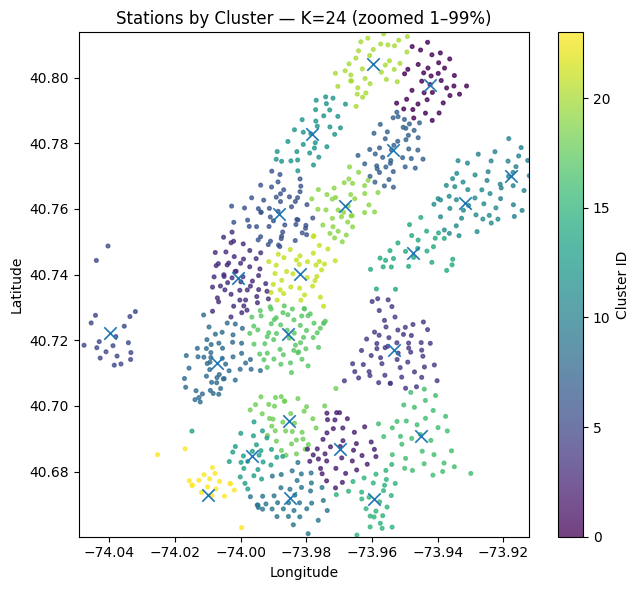

Saved: FIGURES/clusters_K24_zoom.png


In [11]:
# Step 4 — Train model
# === [A] Density map (streaming) + K=24 cluster scatter ======================

FIGURES = Path("./FIGURES"); FIGURES.mkdir(exist_ok=True)


X = station_master[["lat","lon"]].to_numpy()
km = KMeans(n_clusters=24, n_init=10, random_state=42).fit(X)
labels = km.labels_

dfp = station_master.copy()
dfp["cluster_id"] = labels
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(dfp["lon"], dfp["lat"], c=dfp["cluster_id"], s=7, alpha=0.75)
cent = pd.DataFrame(km.cluster_centers_, columns=["lat","lon"])
ax.scatter(cent["lon"], cent["lat"], marker="x", s=80, linewidths=1.2)

# compute bounding box (1st–99th percentiles) and add a small margin for the "zoomed 1–99%" view
lat_lo, lat_hi = np.nanpercentile(station_master["lat"], [1, 99])
lon_lo, lon_hi = np.nanpercentile(station_master["lon"], [1, 99])
# add a tiny margin so points on the exact percentile are not clipped
margin_lat = (lat_hi - lat_lo) * 0.02
margin_lon = (lon_hi - lon_lo) * 0.02
B = {
	"lat_lo": float(lat_lo - margin_lat),
	"lat_hi": float(lat_hi + margin_lat),
	"lon_lo": float(lon_lo - margin_lon),
	"lon_hi": float(lon_hi + margin_lon),
}

ax.set_aspect("equal", adjustable="box")
ax.set_xlim(B["lon_lo"], B["lon_hi"])
ax.set_ylim(B["lat_lo"], B["lat_hi"])

cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Cluster ID")

ax.set_title("Stations by Cluster — K=24 (zoomed 1–99%)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.tight_layout()
plt.savefig(FIGURES / "clusters_K24_zoom.png", dpi=150)
plt.show()
print("Saved:", FIGURES / "clusters_K24_zoom.png")


### Step 5 — Train model
<a id='step-5-train-model'></a>

**Purpose:** Train model.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

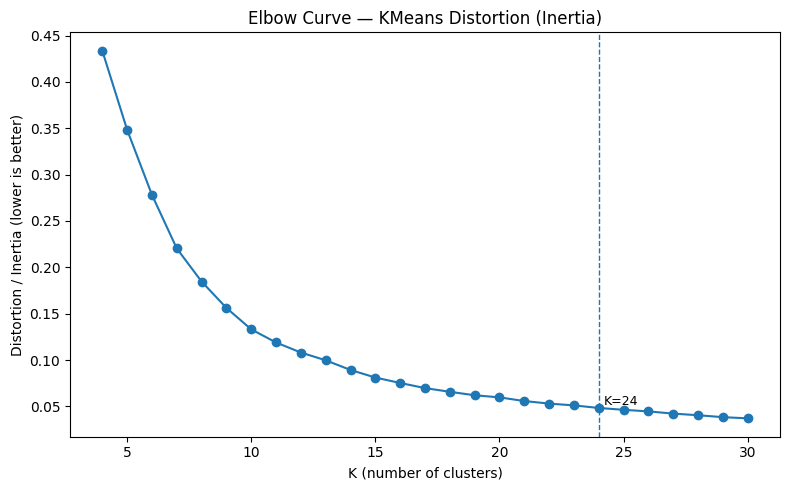

Saved: FIGURES/elbow_curve.png


,K,inertia
0,4,0.433705
1,5,0.348407
2,6,0.278208
3,7,0.220379
4,8,0.184651
5,9,0.156198
6,10,0.133067
7,11,0.118914
8,12,0.108069
9,13,0.099711


In [12]:
# Step 5 — Train model
# === [A] Elbow curve (K-Means distortion) ====================================

FIGURES = Path("./FIGURES"); FIGURES.mkdir(exist_ok=True)

# 1) Feature matrix with cosine-scaled longitude (more isotropic distances)
lat0 = float(station_master["lat"].mean())
X = np.column_stack([
    station_master["lat"].to_numpy(),
    station_master["lon"].to_numpy() * np.cos(np.deg2rad(lat0)),
])

# 2) Sweep K and collect inertia (distortion)
K_VALUES = list(range(4, 31))  # adjust if you want a different span
inertias = []
for K in K_VALUES:
    km = KMeans(n_clusters=K, n_init=10, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)  # sum of squared distances to centroids

# 3) Plot elbow curve
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(K_VALUES, inertias, marker="o")
ax.set_title("Elbow Curve — KMeans Distortion (Inertia)")
ax.set_xlabel("K (number of clusters)")
ax.set_ylabel("Distortion / Inertia (lower is better)")

# mark K
k_mark = 24
if k_mark in K_VALUES:
    ax.axvline(k_mark, linestyle="--", linewidth=1)
    ax.text(k_mark + 0.2, np.interp(k_mark, K_VALUES, inertias),
            f"K={k_mark}", va="bottom", fontsize=9)

plt.tight_layout()
out = FIGURES / "elbow_curve.png"
plt.savefig(out, dpi=150)
plt.show()

print("Saved:", out)
# (Optional) print quick table
display(pd.DataFrame({"K": K_VALUES, "inertia": inertias}).head(10))


### Step 6 — Visualize results
<a id='step-6-visualize-results'></a>

**Purpose:** Visualize results.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

Reading: trips_2018.csv
df_hourly built: (214488, 4) | hours: 2018-01-01 00:00:00 → 2019-01-08 08:00:00 | clusters: 24


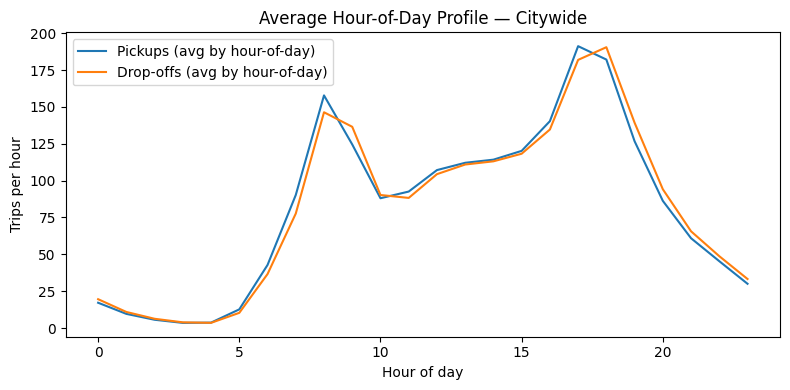

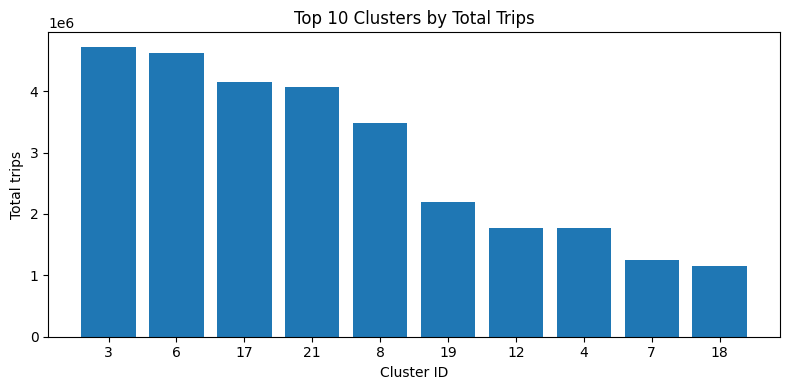

Saved figures:
 - FIGURES/hour_of_day_profile.png
 - FIGURES/top10_clusters_total.png


In [13]:
# Step 6 — Visualize results
# === [B] Hourly aggregation by cluster (streaming) + quick visuals ===========

FIGURES = Path("./FIGURES"); FIGURES.mkdir(exist_ok=True)

# 0) Map station_id -> cluster_id for quick lookup
cluster_lookup = dict(zip(cluster_map["station_id"].astype("Int32"), cluster_map["cluster_id"].astype(int)))

def aggregate_hourly_by_cluster():
    """
    Streams cleaned chunks and accumulates counts:
      - pickups keyed by (hour_start, cluster_of_start_station)
      - dropoffs keyed by (hour_end,   cluster_of_end_station)
    Returns: df_hourly with columns [ts, cluster_id, pickups, dropoffs]
    """
    counter_pick = Counter()
    counter_drop = Counter()
    min_ts = None
    max_ts = None

    for chunk in yield_clean_chunks():
        # START side (pickups)
        if {"hour_start","start_station_id"}.issubset(chunk.columns):
            sid = chunk["start_station_id"].astype("Int32")
            cid = sid.map(cluster_lookup)
            ts  = chunk["hour_start"]
            m = cid.notna() & ts.notna()
            if m.any():
                dfp = pd.DataFrame({"ts": ts[m].values, "cluster_id": cid[m].astype(int).values})
                vc = dfp.value_counts()
                for (tsi, cidi), cnt in vc.items():
                    counter_pick[(tsi, cidi)] += int(cnt)
                # track global time span
                if min_ts is None or dfp["ts"].min() < min_ts: min_ts = dfp["ts"].min()
                if max_ts is None or dfp["ts"].max() > max_ts: max_ts = dfp["ts"].max()

        # END side (drop-offs)
        if {"hour_end","end_station_id"}.issubset(chunk.columns):
            sid = chunk["end_station_id"].astype("Int32")
            cid = sid.map(cluster_lookup)
            ts  = chunk["hour_end"]
            m = cid.notna() & ts.notna()
            if m.any():
                dfd = pd.DataFrame({"ts": ts[m].values, "cluster_id": cid[m].astype(int).values})
                vc = dfd.value_counts()
                for (tsi, cidi), cnt in vc.items():
                    counter_drop[(tsi, cidi)] += int(cnt)
                if min_ts is None or dfd["ts"].min() < min_ts: min_ts = dfd["ts"].min()
                if max_ts is None or dfd["ts"].max() > max_ts: max_ts = dfd["ts"].max()

    # Build dense hourly grid
    all_clusters = np.sort(cluster_map["cluster_id"].unique())
    hours = pd.date_range(min_ts, max_ts, freq="H")
    idx = pd.MultiIndex.from_product([hours, all_clusters], names=["ts","cluster_id"])

    dfh = pd.DataFrame(index=idx).reset_index()
    dfh["pickups"]  = 0
    dfh["dropoffs"] = 0

    # Fill from counters
    if counter_pick:
        tps = pd.DataFrame(
            [(ts, cid, cnt) for (ts, cid), cnt in counter_pick.items()],
            columns=["ts","cluster_id","cnt"]
        )
        dfh = dfh.merge(tps, on=["ts","cluster_id"], how="left").rename(columns={"cnt":"_p"})
        dfh["_p"] = dfh["_p"].fillna(0).astype(int)
        dfh["pickups"] = dfh["_p"]; dfh.drop(columns="_p", inplace=True)

    if counter_drop:
        tds = pd.DataFrame(
            [(ts, cid, cnt) for (ts, cid), cnt in counter_drop.items()],
            columns=["ts","cluster_id","cnt"]
        )
        dfh = dfh.merge(tds, on=["ts","cluster_id"], how="left").rename(columns={"cnt":"_d"})
        dfh["_d"] = dfh["_d"].fillna(0).astype(int)
        dfh["dropoffs"] = dfh["_d"]; dfh.drop(columns="_d", inplace=True)

    # Ensure ints
    dfh[["pickups","dropoffs"]] = dfh[["pickups","dropoffs"]].astype(np.int64)

    print("df_hourly built:", dfh.shape, 
          "| hours:", dfh["ts"].min(), "→", dfh["ts"].max(),
          "| clusters:", dfh["cluster_id"].nunique())
    return dfh

df_hourly = aggregate_hourly_by_cluster()

# --- Visual 1: Average hourly pattern (citywide, by hour-of-day) -------------
prof = (df_hourly
        .assign(hod=df_hourly["ts"].dt.hour)
        .groupby("hod")[["pickups","dropoffs"]]
        .mean()
        .reset_index())

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(prof["hod"], prof["pickups"], label="Pickups (avg by hour-of-day)")
ax.plot(prof["hod"], prof["dropoffs"], label="Drop-offs (avg by hour-of-day)")
ax.set_title("Average Hour-of-Day Profile — Citywide")
ax.set_xlabel("Hour of day"); ax.set_ylabel("Trips per hour")
ax.legend()
plt.tight_layout(); plt.savefig(FIGURES / "hour_of_day_profile.png", dpi=150); plt.show()

# --- Visual 2: Top 10 clusters by total trips (pickups+dropoffs) -------------
totals = (df_hourly.assign(total=df_hourly["pickups"]+df_hourly["dropoffs"])
          .groupby("cluster_id")["total"].sum().sort_values(ascending=False))

top10 = totals.head(10)
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(top10.index.astype(str), top10.values)
ax.set_title("Top 10 Clusters by Total Trips")
ax.set_xlabel("Cluster ID"); ax.set_ylabel("Total trips")
plt.tight_layout(); plt.savefig(FIGURES / "top10_clusters_total.png", dpi=150); plt.show()

print("Saved figures:")
print(" -", FIGURES / "hour_of_day_profile.png")
print(" -", FIGURES / "top10_clusters_total.png")


### Step 7 — Visualize results
<a id='step-7-visualize-results'></a>

**Purpose:** Visualize results.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

Train: 2018-01-01 00:00:00 → 2019-01-08 08:00:00 rows: 179352
Test : 2018-11-01 00:00:00 → 2018-12-31 23:00:00 rows: 35136
Saved metrics → TABLES/metrics.csv


/var/folders/8p/v3dz5r690zl3ndh96xrmb_ph0000gn/T/ipykernel_28879/721438891.py:75: RuntimeWarning: invalid value encountered in scalar divide
  mase = float(mae / den.get(cid, np.nan))


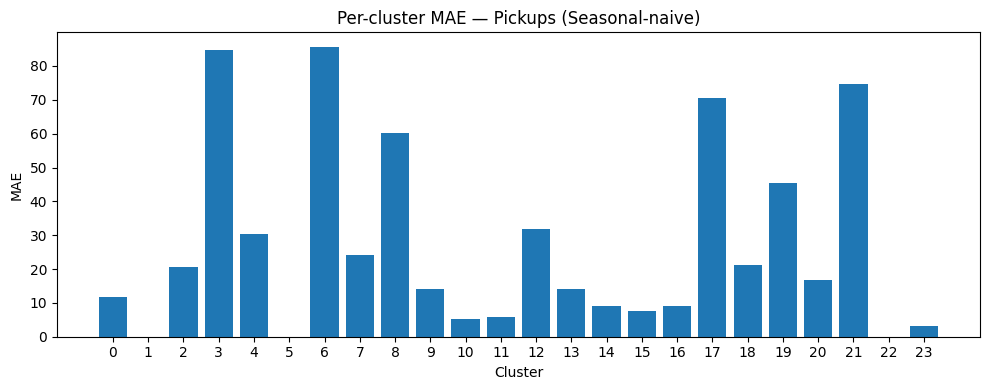

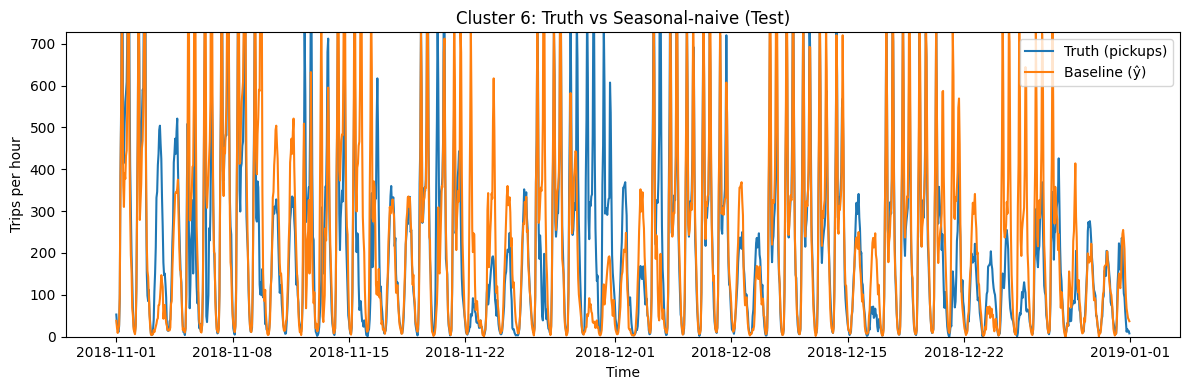

Saved figures:
 - FIGURES/mae_pickups_baseline.png
 - FIGURES/overlay_pickups_baseline.png


In [14]:
# Step 7 — Visualize results
# === [B] Train/Test split + Seasonal-Naive baseline + Metrics + Visuals ======

FIGURES = Path("./FIGURES"); FIGURES.mkdir(exist_ok=True)
TABLES  = Path("./TABLES");  TABLES.mkdir(exist_ok=True)

# --- 1) Split: Jan–Oct (train) vs Nov–Dec (test), across all years ----------
dfx = df_hourly.copy()
dfx["month"] = dfx["ts"].dt.month

train = dfx[dfx["month"].between(1, 10)].drop(columns=["month"])
test  = dfx[dfx["month"].between(11, 12)].drop(columns=["month"])

if test.empty:
    print("⚠️ Test set is empty (no Nov–Dec hours found). "
          "For demo you can temporarily set test = last 20% of time.")
else:
    print("Train:", train["ts"].min(), "→", train["ts"].max(), "rows:", len(train))
    print("Test :", test["ts"].min(),  "→", test["ts"].max(),  "rows:", len(test))

# --- 2) Seasonal-naive forecast with hour-of-day fallback --------------------
H_WEEK = 24 * 7

def seasonal_naive(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    df = (pd.concat([train_df[["ts","cluster_id",target]],
                     test_df[["ts","cluster_id",target]]], ignore_index=True)
            .sort_values(["cluster_id","ts"]).reset_index(drop=True))
    df["y_hat"] = np.nan

    for cid, g in df.groupby("cluster_id", sort=False):
        idx = g.index
        vals = g[target].to_numpy()
        yhat = np.full_like(vals, np.nan, dtype="float64")
        if len(vals) > H_WEEK:
            yhat[H_WEEK:] = vals[:-H_WEEK]
        df.loc[idx, "y_hat"] = yhat

    df["hod"] = df["ts"].dt.hour
    hod_mean = (train_df
                .assign(hod=train_df["ts"].dt.hour)
                .groupby(["cluster_id","hod"])[target]
                .mean()
                .rename("hod_mean"))
    df = df.merge(hod_mean, on=["cluster_id","hod"], how="left")
    df["y_hat"] = df["y_hat"].fillna(df["hod_mean"])

    out = df[(df["ts"] >= test_df["ts"].min()) & (df["ts"] <= test_df["ts"].max())]
    return out[["ts","cluster_id","y_hat"]].reset_index(drop=True)

yhat_pickups_bl  = seasonal_naive(train, test, "pickups")
yhat_dropoffs_bl = seasonal_naive(train, test, "dropoffs")

# --- 3) Metrics --------------------------------------------------------------
def mase_denominator(train_df: pd.DataFrame, target: str, season=H_WEEK):
    den = {}
    for cid, g in train_df.groupby("cluster_id", sort=False):
        y = g[target].astype(float).to_numpy()
        if len(y) > season:
            den[cid] = np.abs(y[season:] - y[:-season]).mean()
        else:
            den[cid] = np.nan
    return den

def evaluate(test_df: pd.DataFrame, yhat_df: pd.DataFrame, target: str, tag: str):
    df = test_df.merge(yhat_df, on=["ts","cluster_id"], how="left")
    df["y_hat"] = df["y_hat"].clip(lower=0)
    df["e"] = df[target] - df["y_hat"]

    den = mase_denominator(train, target)
    rows = []
    for cid, g in df.groupby("cluster_id", sort=False):
        mae  = float(np.mean(np.abs(g["e"])))
        rmse = float(sqrt(np.mean(np.square(g["e"]))))
        wape = float(np.sum(np.abs(g["e"])) / max(1e-9, np.sum(g[target])))
        mase = float(mae / den.get(cid, np.nan))
        rows.append((tag, cid, mae, rmse, mase, wape))
    return pd.DataFrame(rows, columns=["model","cluster_id","MAE","RMSE","MASE","WAPE"])

metrics_pickups  = evaluate(test, yhat_pickups_bl,  "pickups",  "baseline_seasonal_naive")
metrics_dropoffs = evaluate(test, yhat_dropoffs_bl, "dropoffs", "baseline_seasonal_naive")
metrics = pd.concat([metrics_pickups, metrics_dropoffs], ignore_index=True)
metrics.to_csv(TABLES / "metrics.csv", index=False)
print("Saved metrics →", TABLES / "metrics.csv")

# --- 4) Visuals for the report (p95-clipped) --------------------------------
def p95_clip(values: np.ndarray):
    return (0, float(np.nanpercentile(values, 95)))

# (A) Per-cluster MAE — pickups
fig, ax = plt.subplots(figsize=(10, 4))
m = metrics_pickups.sort_values("cluster_id")
ax.bar(m["cluster_id"].astype(str), m["MAE"])
ax.set_title("Per-cluster MAE — Pickups (Seasonal-naive)")
ax.set_xlabel("Cluster"); ax.set_ylabel("MAE")
plt.tight_layout(); plt.savefig(FIGURES / "mae_pickups_baseline.png", dpi=150); plt.show()

# (B) Truth vs baseline for busiest cluster in test
totals_test = (test.assign(total=test["pickups"]+test["dropoffs"])
                    .groupby("cluster_id")["total"].sum())
sample_cluster = int(totals_test.sort_values(ascending=False).index[0])

ts_truth_p = test[test["cluster_id"]==sample_cluster].set_index("ts")["pickups"]
ts_hat_p   = yhat_pickups_bl[yhat_pickups_bl["cluster_id"]==sample_cluster].set_index("ts")["y_hat"]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ts_truth_p.index, ts_truth_p.values, label="Truth (pickups)")
ax.plot(ts_hat_p.index,   ts_hat_p.values,   label="Baseline (ŷ)")
yl = np.r_[ts_truth_p.values, ts_hat_p.values]
lo, hi = p95_clip(yl)
ax.set_ylim(lo, hi)
ax.set_title(f"Cluster {sample_cluster}: Truth vs Seasonal-naive (Test)")
ax.set_xlabel("Time"); ax.set_ylabel("Trips per hour")
ax.legend()
plt.tight_layout(); plt.savefig(FIGURES / "overlay_pickups_baseline.png", dpi=150); plt.show()

print("Saved figures:")
print(" -", FIGURES / "mae_pickups_baseline.png")
print(" -", FIGURES / "overlay_pickups_baseline.png")


### Step 8 — Train model
<a id='step-8-train-model'></a>

**Purpose:** Train model.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

/var/folders/8p/v3dz5r690zl3ndh96xrmb_ph0000gn/T/ipykernel_28879/721438891.py:75: RuntimeWarning: invalid value encountered in scalar divide
  mase = float(mae / den.get(cid, np.nan))


Updated metrics with upgraded Linear model → TABLES/metrics.csv


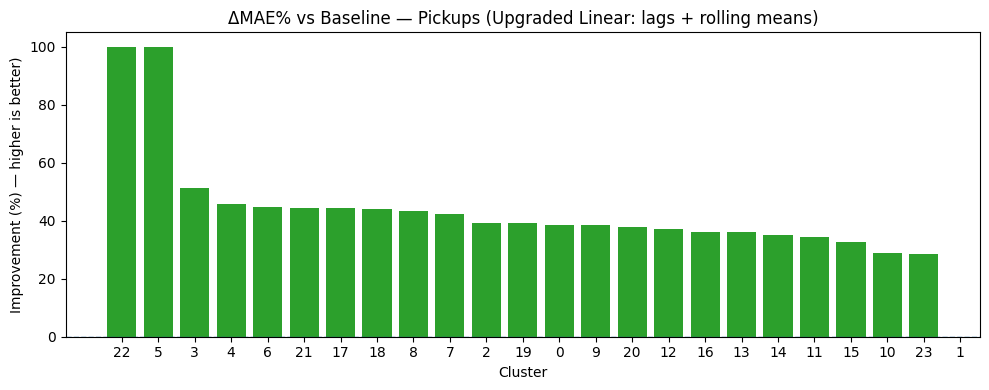

Saved figure:  FIGURES/delta_mae_pct_pickups_linear_upgraded.png


In [15]:
# Step 8 — Train model
# === [B+] Fast model (Upgraded): Linear Regression with richer lags + calendar ==

FIGURES = Path("./FIGURES"); FIGURES.mkdir(exist_ok=True)
TABLES  = Path("./TABLES");  TABLES.mkdir(exist_ok=True)

# ---- feature config ----------------------------------------------------------
LAGS   = [1, 2, 24, 48, 168]   # short + daily + 2-day + weekly
RMEANS = [24, 168]             # rolling means (shifted by 1 hour, leakage-safe)

def build_features_adv(df: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    Leakage-safe features per cluster:
      y, lag_{1,2,24,48,168}, rm_{24,168} (shifted by 1h), and hour/day dummies.
    """
    g = df.sort_values(["cluster_id","ts"]).copy()
    g["y"] = g[target].astype(float)

    # lags
    grp = g.groupby("cluster_id", sort=False)
    for L in LAGS:
        g[f"lag_{L}"] = grp["y"].shift(L)

    # rolling means (shifted by 1h so we don't peek at y_t)
    for W in RMEANS:
        g[f"rm_{W}"] = grp["y"].transform(lambda s: s.shift(1).rolling(window=W, min_periods=W).mean())

    # calendar dummies
    g["hod"] = g["ts"].dt.hour.astype("int8")
    g["dow"] = g["ts"].dt.dayofweek.astype("int8")
    g = pd.get_dummies(g, columns=["hod","dow"], drop_first=True)

    # whitelist columns to avoid any accidental leakage
    keep = ["ts","cluster_id","y"] + [c for c in g.columns if c.startswith(("lag_","rm_","hod_","dow_"))]
    return g[keep]

def fit_predict_linear_adv(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    Fit LinearRegression per cluster using richer lag features; predict the test horizon.
    Falls back to seasonal-naive if a cluster lacks enough training rows with complete lags.
    """
    # Build features on union so test has same dummy columns; all features are shifted/whitelisted.
    full = pd.concat([train_df, test_df], ignore_index=True)
    F = build_features_adv(full, target)

    # Split back to train/test rows
    mask_te = (F["ts"] >= test_df["ts"].min()) & (F["ts"] <= test_df["ts"].max())
    F_tr, F_te = F.loc[~mask_te].copy(), F.loc[mask_te].copy()

    preds = []
    for cid, gtr in F_tr.groupby("cluster_id", sort=False):
        gte = F_te[F_te["cluster_id"] == cid].copy()
        if gte.empty:
            continue

        # Drop rows with any missing predictors (lags/rolling means need history)
        X_cols = [c for c in gtr.columns if c not in {"ts","cluster_id","y"}]
        tr_ok = gtr[X_cols].notna().all(axis=1)

        if tr_ok.sum() < 200:  # guardrail: not enough history with complete features
            tmp = seasonal_naive(train_df[train_df["cluster_id"]==cid],
                                 test_df [test_df ["cluster_id"]==cid], target)
            preds.append(tmp)
            continue

        # Align test columns (missing dummies -> 0)
        for c in X_cols:
            if c not in gte.columns:
                gte[c] = 0.0
        gte[X_cols] = gte[X_cols].fillna(0.0)  # rare edge if early test hours miss rm windows

        # Fit & predict
        lr = LinearRegression()
        lr.fit(gtr.loc[tr_ok, X_cols].to_numpy(dtype="float64"),
               gtr.loc[tr_ok, "y"].to_numpy(dtype="float64"))

        yhat = lr.predict(gte[X_cols].to_numpy(dtype="float64"))
        preds.append(pd.DataFrame({"ts": gte["ts"].values,
                                   "cluster_id": cid,
                                   "y_hat": np.clip(yhat, 0, None)}))

    return pd.concat(preds, ignore_index=True)

# --- Run upgraded model for pickups & drop-offs -------------------------------
yhat_pickups_lin  = fit_predict_linear_adv(train, test, "pickups")
yhat_dropoffs_lin = fit_predict_linear_adv(train, test, "dropoffs")

# --- Evaluate vs baseline (reusing evaluate() from earlier) ------------------
metrics_pickups_lin  = evaluate(test, yhat_pickups_lin,  "pickups",  "linear_lagcal_plus")
metrics_dropoffs_lin = evaluate(test, yhat_dropoffs_lin, "dropoffs", "linear_lagcal_plus")
metrics_upg = pd.concat([metrics, metrics_pickups_lin, metrics_dropoffs_lin], ignore_index=True)
metrics_upg.to_csv(TABLES / "metrics.csv", index=False)
print("Updated metrics with upgraded Linear model →", TABLES / "metrics.csv")

# --- Visual: Sorted ΔMAE% for pickups (Baseline − Upgraded Linear) -----------
m_base = metrics[metrics["model"].str.contains("baseline", case=False) & metrics["cluster_id"].notna()]
mb = m_base.set_index("cluster_id")["MAE"]
ml = metrics_pickups_lin.set_index("cluster_id")["MAE"]
common = mb.index.intersection(ml.index)
delta_pct = ((mb.loc[common] - ml.loc[common]) / mb.loc[common] * 100.0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
colors = ["#2ca02c" if v>0 else "#d62728" for v in delta_pct.values]
ax.bar(delta_pct.index.astype(str), delta_pct.values, color=colors)
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("ΔMAE% vs Baseline — Pickups (Upgraded Linear: lags + rolling means)")
ax.set_xlabel("Cluster"); ax.set_ylabel("Improvement (%) — higher is better)")
plt.tight_layout(); plt.savefig(FIGURES / "delta_mae_pct_pickups_linear_upgraded.png", dpi=150); plt.show()

print("Saved figure: ", FIGURES / "delta_mae_pct_pickups_linear_upgraded.png")


### Step 9 — Train model
<a id='step-9-train-model'></a>

**Purpose:** Train model.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

/var/folders/8p/v3dz5r690zl3ndh96xrmb_ph0000gn/T/ipykernel_28879/721438891.py:75: RuntimeWarning: invalid value encountered in scalar divide
  mase = float(mae / den.get(cid, np.nan))
/var/folders/8p/v3dz5r690zl3ndh96xrmb_ph0000gn/T/ipykernel_28879/721438891.py:75: RuntimeWarning: invalid value encountered in scalar divide
  mase = float(mae / den.get(cid, np.nan))


Saved → TABLES/metrics_one_step.csv


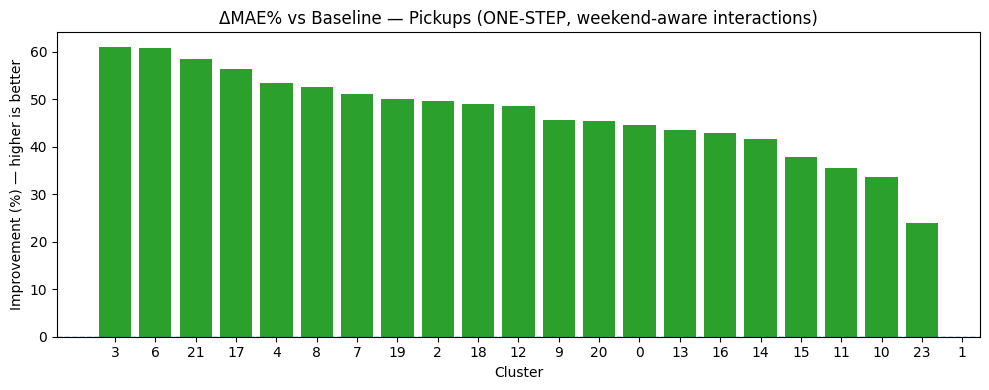

In [16]:
# Step 9 — Train model
# === [C] ONE-STEP (leakage-safe) — HoW + Residualization + weekend interactions ===

FIGURES = Path("./FIGURES"); FIGURES.mkdir(exist_ok=True)
TABLES  = Path("./TABLES");  TABLES.mkdir(exist_ok=True)

# Lags (short + 1/2-day + daily + 2-day + 3-day + weekly)
LAGS   = [1, 2, 3, 4, 6, 12, 24, 48, 72, 96, 168]
RMEANS = [24, 168]  # shifted by 1h (window ends at t-1)

def _hour_of_week(ts: pd.Series) -> pd.Series:
    # 0..167
    return (ts.dt.dayofweek.astype(int) * 24 + ts.dt.hour.astype(int)).astype("int16")

def build_features_onestep(df: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    Leakage-safe features for ONE-STEP (no holidays):
      - residualization: y_res = y - lag_168  (y_base = lag_168)
      - lags: 1,2,3,4,6,12,24,48,72,96,168
      - shifted rolling means: rm_24, rm_168 (window ends at t-1)
      - Hour-of-Week dummies how_*
      - weekend flags: is_weekend, is_friday, is_sunday
      - NEW: weekend interactions with key seasonal signals:
            lag_24_wk, lag_168_wk, rm_24_wk, rm_168_wk
    """
    g = df.sort_values(["cluster_id","ts"]).copy()
    g["y"] = g[target].astype(float)

    grp = g.groupby("cluster_id", sort=False)
    for L in LAGS:
        g[f"lag_{L}"] = grp["y"].shift(L)
    for W in RMEANS:
        g[f"rm_{W}"] = grp["y"].transform(lambda s: s.shift(1).rolling(W, min_periods=W).mean())

    # residualization to last week
    g["y_base"] = g["lag_168"]
    g["y_res"]  = g["y"] - g["y_base"]

    # calendar (weekend only)
    g["is_weekend"] = g["ts"].dt.dayofweek.isin([5, 6]).astype("int8")
    g["is_friday"]  = (g["ts"].dt.dayofweek == 4).astype("int8")
    g["is_sunday"]  = (g["ts"].dt.dayofweek == 6).astype("int8")

    # Hour-of-Week dummies
    g["how"] = _hour_of_week(g["ts"])
    g = pd.get_dummies(g, columns=["how"], prefix="how", drop_first=True)

    # Weekend interactions with key signals
    for base in ["lag_24","lag_168","rm_24","rm_168"]:
        g[f"{base}_wk"] = g[base] * g["is_weekend"]

    keep = ["ts","cluster_id","y","y_base","y_res"] + \
           [c for c in g.columns if c.startswith(("lag_","rm_","how_","is_"))]
    g = g[keep]
    assert not any(c in g.columns for c in ("pickups","dropoffs")), "Leakage risk: raw target present!"
    return g

def one_step_linear_how_resid(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    Train Ridge per cluster on TRAIN (target = y_res) and predict ONE-STEP on TEST:
      ŷ_t = y_{t−168} + r̂_t
    With weekend interactions + light weekend up-weighting.
    """
    full = pd.concat([train_df, test_df], ignore_index=True)
    F    = build_features_onestep(full, target)

    mask_te = (F["ts"] >= test_df["ts"].min()) & (F["ts"] <= test_df["ts"].max())
    F_tr, F_te = F.loc[~mask_te].copy(), F.loc[mask_te].copy()

    preds = []
    core_req = ["lag_24","lag_168","rm_24","rm_168"]  # must be present

    for cid, gtr in F_tr.groupby("cluster_id", sort=False):
        gte = F_te[F_te["cluster_id"]==cid].copy()
        if gte.empty:
            continue

        X_cols = [c for c in gtr.columns if c not in {"ts","cluster_id","y","y_res","y_base"}]
        tr_ok = gtr[core_req].notna().all(axis=1)
        if tr_ok.sum() < 200:
            tmp = seasonal_naive(train_df[train_df["cluster_id"]==cid],
                                 test_df [test_df ["cluster_id"]==cid], target)
            preds.append(tmp); continue

        # Fill non-core NaNs with 0 (safe for dummies & optional lags)
        non_core = [c for c in X_cols if c not in core_req]
        gtr.loc[:, non_core] = gtr.loc[:, non_core].fillna(0.0)
        gte.loc[:, non_core] = gte.loc[:, non_core].fillna(0.0)
        for c in X_cols:
            if c not in gte.columns:
                gte[c] = 0.0

        # Weekend up-weighting
        w = np.where(gtr["is_weekend"]==1, 1.8, 1.0).astype("float64")

        alpha = 1.2 if tr_ok.sum() >= 1000 else 2.0
        mdl = Ridge(alpha=alpha)
        mdl.fit(gtr.loc[tr_ok, X_cols].to_numpy(dtype="float64"),
                gtr.loc[tr_ok, "y_res"].to_numpy(dtype="float64"),
                sample_weight=w[tr_ok])

        te_ok = gte[core_req + ["y_base"]].notna().all(axis=1)
        yhat  = np.full(len(gte), np.nan, dtype="float64")
        if te_ok.any():
            rhat = mdl.predict(gte.loc[te_ok, X_cols].to_numpy(dtype="float64"))
            yhat[te_ok.values] = gte.loc[te_ok, "y_base"].to_numpy(dtype="float64") + rhat
        if (~te_ok).any():
            yhat[~te_ok.values] = gte.loc[~te_ok, "y_base"].to_numpy(dtype="float64")

        preds.append(pd.DataFrame({"ts": gte["ts"].values, "cluster_id": cid,
                                   "y_hat": np.clip(yhat, 0, None)}))

    return pd.concat(preds, ignore_index=True)

# --- run strict one-step for pickups & drop-offs ------------------------------
yhat_pickups_1s_lin  = one_step_linear_how_resid(train, test, "pickups")
yhat_dropoffs_1s_lin = one_step_linear_how_resid(train, test, "dropoffs")

# Baseline (seasonal-naive one-step)
yhat_pickups_1s_bl  = seasonal_naive(train, test, "pickups")
yhat_dropoffs_1s_bl = seasonal_naive(train, test, "dropoffs")

# --- metrics (reuse evaluate()) ----------------------------------------------
metrics_pickups_bl   = evaluate(test, yhat_pickups_1s_bl,  "pickups",  tag="baseline_seasonal_naive_1step")
metrics_dropoffs_bl  = evaluate(test, yhat_dropoffs_1s_bl, "dropoffs", tag="baseline_seasonal_naive_1step")
metrics_pickups_lin  = evaluate(test, yhat_pickups_1s_lin, "pickups",  tag="linear_how_resid_weekend_1step")
metrics_dropoffs_lin = evaluate(test, yhat_dropoffs_1s_lin,"dropoffs", tag="linear_how_resid_weekend_1step")

metrics_1step = pd.concat([metrics_pickups_bl, metrics_dropoffs_bl,
                           metrics_pickups_lin, metrics_dropoffs_lin], ignore_index=True)
metrics_1step.to_csv(TABLES / "metrics_one_step.csv", index=False)
print("Saved →", TABLES / "metrics_one_step.csv")

# --- visuals unchanged (bar of ΔMAE%) -----------------------------------------
mb = metrics_pickups_bl.set_index("cluster_id")["MAE"]
ml = metrics_pickups_lin.set_index("cluster_id")["MAE"]
common = mb.index.intersection(ml.index)
delta_pct = ((mb.loc[common] - ml.loc[common]) / mb.loc[common] * 100.0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(delta_pct.index.astype(str), delta_pct.values,
       color=["#2ca02c" if v>0 else "#d62728" for v in delta_pct.values])
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("ΔMAE% vs Baseline — Pickups (ONE-STEP, weekend-aware interactions)")
ax.set_xlabel("Cluster"); ax.set_ylabel("Improvement (%) — higher is better")
plt.tight_layout(); plt.savefig(FIGURES / "delta_mae_pct_pickups_onestep_weekend.png", dpi=150); plt.show()


### Step 10 — Train model
<a id='step-10-train-model'></a>

**Purpose:** Train model.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

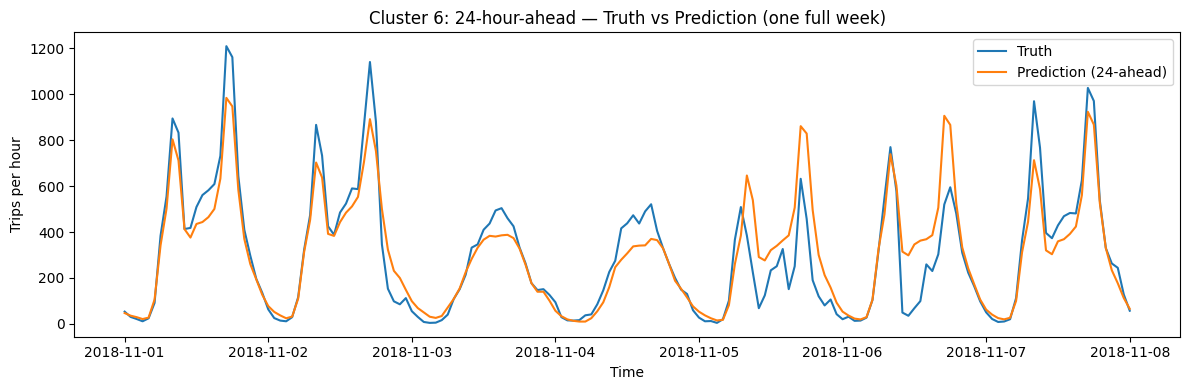

Saved → FIGURES/overlay_pickups_24ahead_week.png


In [17]:
# Step 10 — Train model
# === 24-ahead — HoW + Residuals + weekend interactions (FAST) — weekly overlay only ===

FIGURES = Path("./FIGURES"); FIGURES.mkdir(exist_ok=True)

LAGS   = [1,2,3,4,6,12,24,48,72,96,168]
RMEANS = [24,168]

def _hour_of_week(ts: pd.Series) -> pd.Series:
    return (ts.dt.dayofweek.astype(int) * 24 + ts.dt.hour.astype(int)).astype("int16")  # 0..167

def _build_train_matrix(train_df: pd.DataFrame, target: str):
    g = train_df.sort_values(["cluster_id","ts"]).copy()
    g["y"] = g[target].astype(float)
    grp = g.groupby("cluster_id", sort=False)

    for L in LAGS:
        g[f"lag_{L}"] = grp["y"].shift(L)
    for W in RMEANS:
        g[f"rm_{W}"] = grp["y"].transform(lambda s: s.shift(1).rolling(W, min_periods=W).mean())

    g["y_base"] = g["lag_168"]
    g["y_res"]  = g["y"] - g["y_base"]

    g["how"] = _hour_of_week(g["ts"])
    g["is_weekend"] = g["ts"].dt.dayofweek.isin([5,6]).astype("int8")
    g["is_friday"]  = (g["ts"].dt.dayofweek == 4).astype("int8")
    g["is_sunday"]  = (g["ts"].dt.dayofweek == 6).astype("int8")

    g = pd.get_dummies(g, columns=["how"], prefix="how", drop_first=True)

    # Weekend interactions with key signals
    for base in ["lag_24","lag_168","rm_24","rm_168"]:
        g[f"{base}_wk"] = g[base] * g["is_weekend"]

    X_cols = [c for c in g.columns if c.startswith(("lag_","rm_","how_","is_"))]

    models, how_means, how_p95 = {}, {}, {}
    for cid, sub in g.groupby("cluster_id", sort=False):
        how_idx = (sub["ts"].dt.dayofweek*24 + sub["ts"].dt.hour).astype(int)
        hm  = sub.groupby(how_idx)["y"].mean().to_dict()
        hp  = sub.groupby(how_idx)["y"].quantile(0.95).to_dict()
        cid_int = int(cid)
        how_means[cid_int] = {int(k): float(v) for k,v in hm.items()}
        how_p95[cid_int]   = {int(k): float(v) for k,v in hp.items()}

        core_req = ["lag_24","lag_168","rm_24","rm_168"]
        ok = sub[core_req].notna().all(axis=1)
        if ok.sum() < 300:
            models[cid_int] = None
            continue

        non_core = [c for c in X_cols if c not in core_req]
        sub.loc[:, non_core] = sub.loc[:, non_core].fillna(0.0)

        # Weekend up-weighting
        w = np.where(sub["is_weekend"]==1, 1.8, 1.0).astype("float64")

        alpha = 1.2 if ok.sum() >= 1200 else 2.0
        mdl = Ridge(alpha=alpha)
        mdl.fit(sub.loc[ok, X_cols].to_numpy(dtype="float64"),
                sub.loc[ok, "y_res"].to_numpy(dtype="float64"),
                sample_weight=w[ok])
        models[cid_int] = mdl

    return models, X_cols, how_means, how_p95

# O(1) rolling mean buffers
def _init_rolling_buffers(hist: pd.Series, t0: pd.Timestamp):
    dq24, dq168 = deque(maxlen=24), deque(maxlen=168)
    s24 = s168 = 0.0
    for k in range(24, 0, -1):
        v = hist.get(t0 - pd.Timedelta(hours=k), np.nan)
        if not np.isnan(v): dq24.append(float(v)); s24 += float(v)
    for k in range(168, 0, -1):
        v = hist.get(t0 - pd.Timedelta(hours=k), np.nan)
        if not np.isnan(v): dq168.append(float(v)); s168 += float(v)
    return dq24, s24, dq168, s168

def _rm_from_buffer(dq, s, W):
    return (s / W) if len(dq) == W else np.nan

def rolling_forecast_24(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    models, X_cols, how_means, how_p95 = _build_train_matrix(train_df, target)
    preds = []

    full = pd.concat([train_df[["ts","cluster_id",target]],
                      test_df [["ts","cluster_id",target]]], ignore_index=True)
    clusters = np.sort(test_df["cluster_id"].unique())
    days = pd.to_datetime(test_df["ts"].dt.floor("D").unique())

    how_cols = [c for c in X_cols if c.startswith("how_")]
    core_req = ["lag_24","lag_168","rm_24","rm_168"]

    for cid in clusters:
        cid = int(cid)
        mdl = models.get(cid)
        series = full[full["cluster_id"]==cid].sort_values("ts").set_index("ts")[target].astype(float)
        hist = series.copy()

        t0 = days.min()
        dq24, s24, dq168, s168 = _init_rolling_buffers(hist, t0)

        for d in days:
            for h in range(24):
                t = d + pd.Timedelta(hours=h)

                feats = {}
                # HoW
                how = int(t.dayofweek*24 + t.hour)
                feats[f"how_{how}"] = 1.0
                # weekend flags
                feats["is_weekend"] = int(t.weekday() >= 5)
                feats["is_friday"]  = int(t.weekday() == 4)
                feats["is_sunday"]  = int(t.weekday() == 6)
                # lags
                for L in LAGS:
                    feats[f"lag_{L}"] = hist.get(t - pd.Timedelta(hours=L), np.nan)
                # rolling means (buffers)
                feats["rm_24"]  = _rm_from_buffer(dq24,  s24,  24)
                feats["rm_168"] = _rm_from_buffer(dq168, s168, 168)
                # weekend interactions
                feats["lag_24_wk"]  = feats["lag_24"]  * feats["is_weekend"] if not np.isnan(feats["lag_24"])  else np.nan
                feats["lag_168_wk"] = feats["lag_168"] * feats["is_weekend"] if not np.isnan(feats["lag_168"]) else np.nan
                feats["rm_24_wk"]   = feats["rm_24"]   * feats["is_weekend"] if not np.isnan(feats["rm_24"])   else np.nan
                feats["rm_168_wk"]  = feats["rm_168"]  * feats["is_weekend"] if not np.isnan(feats["rm_168"])  else np.nan

                # baseline & features
                y_base = hist.get(t - pd.Timedelta(hours=168), np.nan)
                if np.isnan(y_base):
                    y_base = how_means.get(cid, {}).get(how, 0.0)

                x = []
                core_missing = False
                for c in X_cols:
                    val = feats.get(c, 0.0 if c.startswith(("how_","is_")) else np.nan)
                    if c in core_req and (not isinstance(val, (int,float)) or np.isnan(val)):
                        core_missing = True
                    x.append(val if not (isinstance(val,float) and np.isnan(val)) else 0.0)
                x = np.asarray(x, dtype="float64")

                if mdl is None or core_missing:
                    yhat = y_base
                else:
                    rhat = float(mdl.predict(x.reshape(1, -1))[0])
                    yhat = y_base + rhat

                # cap to HoW p95; floor 0
                cap = how_p95.get(cid, {}).get(how, np.inf)
                yhat = max(0.0, min(yhat, cap))

                preds.append((t, cid, yhat))
                hist.loc[t] = yhat

                # update buffers
                if len(dq24) == 24:   s24  -= dq24[0]
                if len(dq168) == 168: s168 -= dq168[0]
                dq24.append(yhat);   s24  += yhat
                dq168.append(yhat); s168 += yhat

    out = (pd.DataFrame(preds, columns=["ts","cluster_id","y_hat"])
             .sort_values(["ts","cluster_id"]).reset_index(drop=True))
    return out

# --- Forecast 24h ahead for pickups & drop-offs -------------------------------
yhat_pickups_24  = rolling_forecast_24(train, test, "pickups")
yhat_dropoffs_24 = rolling_forecast_24(train, test, "dropoffs")

# --- Plot (two lines) for a full week on busiest cluster ----------------------
totals_test = (test.assign(total=test["pickups"]+test["dropoffs"])
                    .groupby("cluster_id")["total"].sum())
cid = int(totals_test.sort_values(ascending=False).index[0])

start_week = test["ts"].min().ceil("D")
end_week   = start_week + pd.Timedelta(days=7)

truth = test[(test["cluster_id"]==cid) & (test["ts"].between(start_week, end_week))]\
        .set_index("ts")["pickups"]
pred  = yhat_pickups_24[(yhat_pickups_24["cluster_id"]==cid) & (yhat_pickups_24["ts"].between(start_week, end_week))]\
        .set_index("ts")["y_hat"]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(truth.index, truth.values, label="Truth")
ax.plot(pred.index,  pred.values,  label="Prediction (24-ahead)")
ax.set_title(f"Cluster {cid}: 24-hour-ahead — Truth vs Prediction (one full week)")
ax.set_xlabel("Time"); ax.set_ylabel("Trips per hour")
ax.legend()
plt.tight_layout(); plt.savefig(FIGURES / "overlay_pickups_24ahead_week.png", dpi=150); plt.show()
print("Saved →", FIGURES / "overlay_pickups_24ahead_week.png")


### Step 11 — Visualize results
<a id='step-11-visualize-results'></a>

**Purpose:** Visualize results.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

[Window] Cluster 6 — 2018-11-01 to 2018-11-11  (hours: 241)
Pickups : {'MAE': 78.563, 'RMSE': 128.073, 'WAPE': 0.275}
Drop-offs: {'MAE': 79.878, 'RMSE': 129.162, 'WAPE': 0.279}


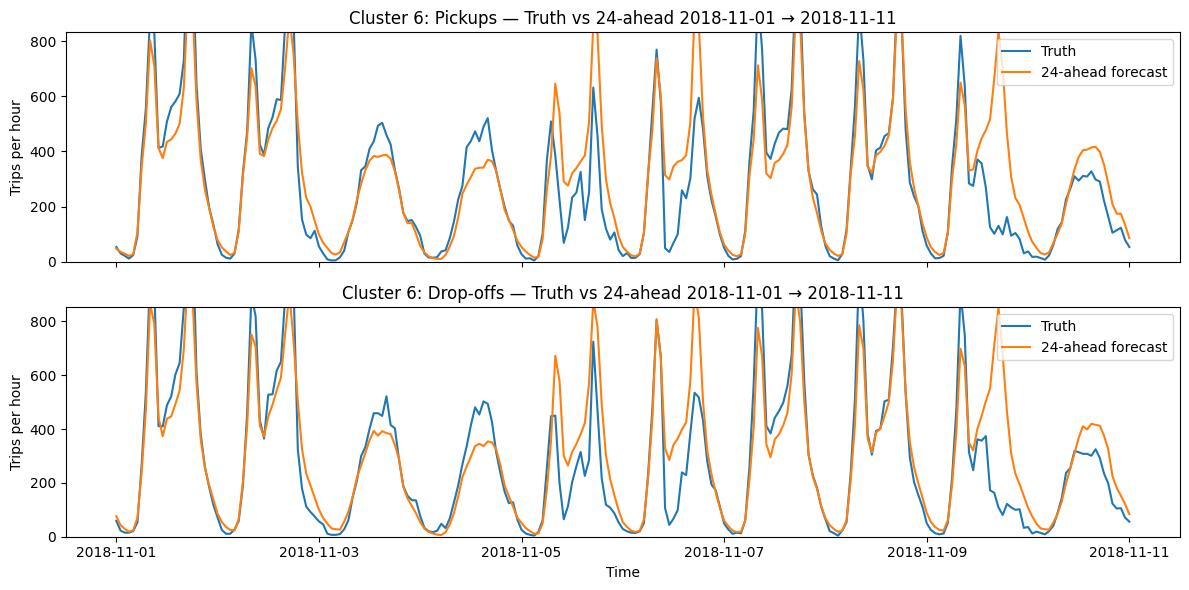

Saved figure → FIGURES/overlay_cluster6_2018-11-01_→_2018-11-11.png


In [18]:
# Step 11 — Visualize results
# === Test any window: pick a start day and number of days =====================

# --- PARAMETERS ---------------------------------------------------------------
START_DAY  = pd.Timestamp("2018-11-01")   # any day inside TEST interval
NUM_DAYS   = 10                        # length of window in days
CLUSTER_ID = 6                       # None for citywide; or e.g. 6 for a single cluster
# disable saving of figures - only display them in the notebook
SAVE_FIGURES = False

if not SAVE_FIGURES:
    # monkeypatch plt.savefig to be a no-op so existing code that calls savefig still displays
    def _noop_savefig(*args, **kwargs):
        return None
    plt.savefig = _noop_savefig
FIGURES = Path("./FIGURES"); FIGURES.mkdir(exist_ok=True)

# --- helpers -----------------------------------------------------------------
def _slice_window(truth_df, pred_df, target, start_day, num_days, cluster_id=None):
    start = pd.Timestamp(start_day).floor("D")
    end   = start + pd.Timedelta(days=num_days)
    t = truth_df[truth_df["ts"].between(start, end)].copy()
    p = pred_df[pred_df["ts"].between(start, end)].copy()
    if cluster_id is not None:
        t = t[t["cluster_id"]==cluster_id]
        p = p[p["cluster_id"]==cluster_id]
    # align on ts,cluster_id
    m = t[["ts","cluster_id",target]].merge(
        p[["ts","cluster_id","y_hat"]],
        on=["ts","cluster_id"],
        how="left"
    ).rename(columns={target: "y"})
    return m, start, end

def _window_metrics(m):
    y, yhat = m["y"].to_numpy(dtype="float64"), m["y_hat"].to_numpy(dtype="float64")
    mask = ~np.isnan(yhat)
    if mask.sum()==0:
        return {"MAE": np.nan, "RMSE": np.nan, "WAPE": np.nan}
    e = y[mask] - yhat[mask]
    mae  = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e**2)))
    wape = float(np.sum(np.abs(e)) / max(1.0, np.sum(np.abs(y[mask]))))
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape}

def _plot_overlay(m_pick, m_drop, title_suffix, cluster_id=None):
    # aggregate if citywide; otherwise keep single cluster
    if cluster_id is None:
        gp_pick = m_pick.groupby("ts")[["y","y_hat"]].sum()
        gp_drop = m_drop.groupby("ts")[["y","y_hat"]].sum()
        label = "Citywide (sum)"
    else:
        gp_pick = m_pick.set_index("ts")[["y","y_hat"]]
        gp_drop = m_drop.set_index("ts")[["y","y_hat"]]
        label = f"Cluster {cluster_id}"

    def p95_clip(vals):
        return (0, float(np.nanpercentile(np.asarray(vals, dtype="float64"), 95)))

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    # pickups
    axes[0].plot(gp_pick.index, gp_pick["y"],     label="Truth")
    axes[0].plot(gp_pick.index, gp_pick["y_hat"], label="24-ahead forecast")
    lo, hi = p95_clip(np.r_[gp_pick["y"].values, gp_pick["y_hat"].values])
    axes[0].set_ylim(lo, hi)
    axes[0].set_title(f"{label}: Pickups — Truth vs 24-ahead {title_suffix}")
    axes[0].set_ylabel("Trips per hour"); axes[0].legend()

    # drop-offs
    axes[1].plot(gp_drop.index, gp_drop["y"],     label="Truth")
    axes[1].plot(gp_drop.index, gp_drop["y_hat"], label="24-ahead forecast")
    lo, hi = p95_clip(np.r_[gp_drop["y"].values, gp_drop["y_hat"].values])
    axes[1].set_ylim(lo, hi)
    axes[1].set_title(f"{label}: Drop-offs — Truth vs 24-ahead {title_suffix}")
    axes[1].set_xlabel("Time"); axes[1].set_ylabel("Trips per hour"); axes[1].legend()

    plt.tight_layout()
    fname = FIGURES / f"overlay_{'city' if cluster_id is None else f'cluster{cluster_id}'}_{title_suffix.replace(' ','_').replace(':','')}.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    print("Saved figure →", fname)

# --- run ---------------------------------------------------------------------
# Validate bounds
test_days = pd.to_datetime(test["ts"].dt.floor("D").unique())
test_min, test_max = test_days.min(), test_days.max()
if not (test_min <= START_DAY <= test_max):
    raise ValueError(f"START_DAY must be within TEST [{test_min.date()} .. {test_max.date()}]")

# Slice windows and compute metrics
mp, start, end = _slice_window(test, yhat_pickups_24,  "pickups",  START_DAY, NUM_DAYS, CLUSTER_ID)
md, _,    _    = _slice_window(test, yhat_dropoffs_24, "dropoffs", START_DAY, NUM_DAYS, CLUSTER_ID)

metrics_pick = _window_metrics(mp)
metrics_drop = _window_metrics(md)

# Print window summary
who = "Citywide" if CLUSTER_ID is None else f"Cluster {CLUSTER_ID}"
print(f"[Window] {who} — {start.date()} to {end.date()}  (hours: {len(mp['ts'].unique())})")
print("Pickups :", {k: round(v, 3) for k,v in metrics_pick.items()})
print("Drop-offs:", {k: round(v, 3) for k,v in metrics_drop.items()})

# Plot overlays
_plot_overlay(mp, md, title_suffix=f"{start.date()} → {end.date()}", cluster_id=CLUSTER_ID)


### Step 12 — Visualize results
<a id='step-12-visualize-results'></a>

**Purpose:** Visualize results.

> Tip: See comments at the top of the next code cell for a one‑line reminder.

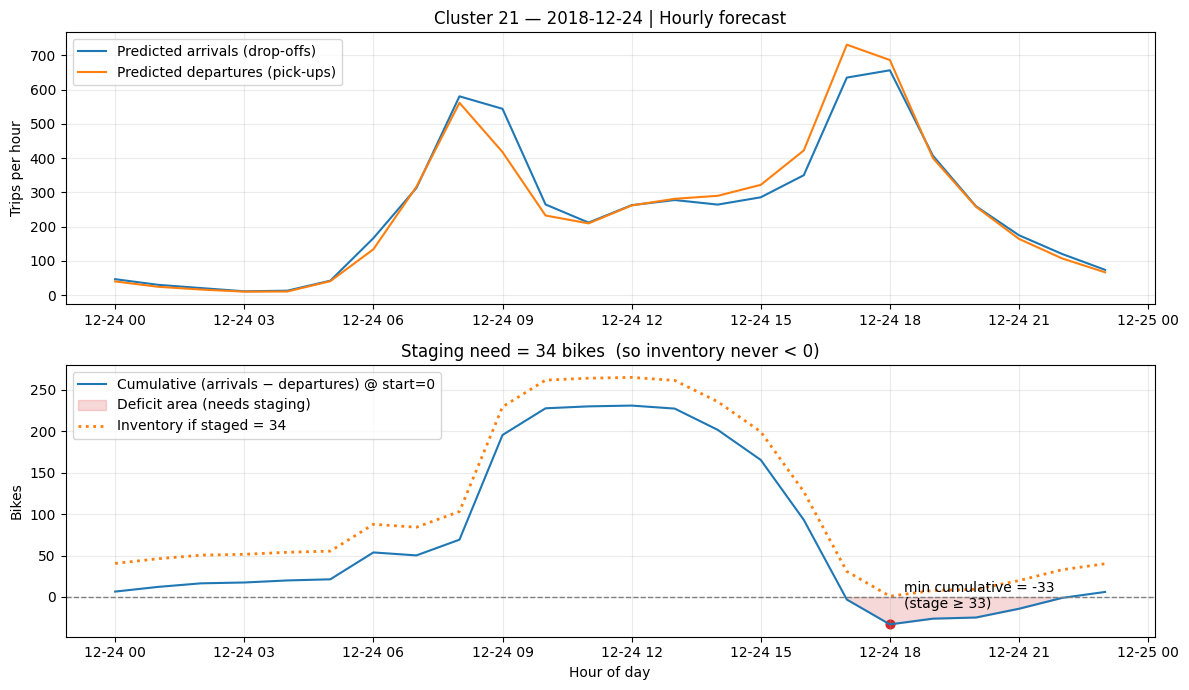

Cluster 21 — 2018-12-24
  Bikes to stage overnight: 34
  Governing dip at ~18:00 (cum arrivals−departures = -33)
  End-of-day inventory if staged: 40


In [19]:
# Step 12 — Visualize results
# === Intuitive rebalancing view for a selected cluster & day ==================
# Top: hourly predicted pickups & drop-offs
# Bottom: cumulative (arrivals − departures). Bikes to stage = −min cumulative.


# --------- SELECT HERE --------------------------------------------------------
CLUSTER = 21                          # <- cluster id to inspect
THE_DAY = pd.Timestamp("2018-12-24")  # <- any date in the test horizon

# Inputs expected to exist:
#   yhat_pickups_24  (ts, cluster_id, y_hat)  # departures
#   yhat_dropoffs_24 (ts, cluster_id, y_hat)  # arrivals

def _slice_day(df, cid, day, colname):
    m = (df["cluster_id"]==cid) & (df["ts"].dt.floor("D")==day)
    g = (df.loc[m, ["ts","y_hat"]]
           .rename(columns={"y_hat": colname})
           .set_index("ts"))
    hours = pd.date_range(day, periods=24, freq="H")
    g = g.reindex(hours).fillna(0.0).reset_index().rename(columns={"index":"ts"})
    return g

arr = _slice_day(yhat_dropoffs_24, CLUSTER, THE_DAY, "arr")  # arrivals
dep = _slice_day(yhat_pickups_24,  CLUSTER, THE_DAY, "dep")  # departures

daydf = (arr.merge(dep, on="ts", how="inner")
            .sort_values("ts"))

# --- Core quantities (intuitive sign convention) ------------------------------
# Positive = bikes arriving, Negative = bikes leaving
daydf["net"] = daydf["arr"] - daydf["dep"]

# Cumulative if you start the day with 0 bikes at midnight
daydf["cum_net"] = daydf["net"].cumsum()

# Bikes to stage so inventory never < 0: lift the lowest dip to zero
min_cum = float(daydf["cum_net"].min())
bikes_to_stage = int(np.ceil(max(0.0, -min_cum)))

# Inventory path if we stage that many at 00:00
daydf["inventory_if_staged"] = bikes_to_stage + daydf["cum_net"]

# Markers
i_min = int(daydf["cum_net"].idxmin())
t_min = daydf.loc[i_min, "ts"]
v_min = float(daydf.loc[i_min, "cum_net"])

# --- Figure -------------------------------------------------------------------
fig = plt.figure(figsize=(12,7))

# (1) Hourly flows
ax1 = plt.subplot(2,1,1)
ax1.plot(daydf["ts"], daydf["arr"], label="Predicted arrivals (drop-offs)")
ax1.plot(daydf["ts"], daydf["dep"], label="Predicted departures (pick-ups)")
ax1.set_title(f"Cluster {CLUSTER} — {THE_DAY.date()} | Hourly forecast")
ax1.set_ylabel("Trips per hour")
ax1.legend(loc="upper left")
ax1.grid(alpha=0.25)

# (2) Cumulative & staging
ax2 = plt.subplot(2,1,2, sharex=ax1)
# Cumulative (arrivals − departures) with deficits shaded
ax2.plot(daydf["ts"], daydf["cum_net"], label="Cumulative (arrivals − departures) @ start=0")

# Shade deficit (below 0)
ax2.fill_between(daydf["ts"], daydf["cum_net"], 0, where=(daydf["cum_net"]<0),
                 alpha=0.18, color="tab:red", label="Deficit area (needs staging)")

# Inventory path if we stage the required amount
ax2.plot(daydf["ts"], daydf["inventory_if_staged"], linestyle=":", linewidth=2,
         label=f"Inventory if staged = {bikes_to_stage}")

# Zero baseline
ax2.axhline(0, linestyle="--", linewidth=1, color="grey")

# Annotate governing dip
ax2.scatter([t_min], [v_min], s=40, color="tab:red")
ax2.annotate(f"min cumulative = {int(round(v_min))}\n(stage ≥ {-int(round(v_min))})",
             xy=(t_min, v_min), xytext=(10, 12), textcoords="offset points")

ax2.set_title(f"Staging need = {bikes_to_stage} bikes  (so inventory never < 0)")
ax2.set_xlabel("Hour of day"); ax2.set_ylabel("Bikes")
ax2.legend(loc="upper left")
ax2.grid(alpha=0.25)

plt.tight_layout()
plt.show()

print(f"Cluster {CLUSTER} — {THE_DAY.date()}")
print(f"  Bikes to stage overnight: {bikes_to_stage}")
print(f"  Governing dip at ~{t_min.strftime('%H:%M')} (cum arrivals−departures = {v_min:.0f})")
print(f"  End-of-day inventory if staged: {int(round(daydf['inventory_if_staged'].iloc[-1]))}")
